In [102]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100) 

from os import path
import pickle

import sys
sys.path.append('..')
import src.functions.my_functions as my_func

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
7
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics.scorer import make_scorer

from sklearn.metrics import f1_score, recall_score, precision_score, fbeta_score

from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel, SelectKBest, SelectPercentile, RFECV, f_classif

In [100]:
from imp import reload
reload(my_func)

<module 'src.functions.my_functions' from '..\\src\\functions\\my_functions.py'>

### Import

In [4]:
data = {}

ds = ['train', 'train_target', 'test', 'test_target']
d = ['..', 'data', 'processed']

for s in ds:    
    fn = 'loan_'+s+'.p'
    fp = path.join(*d, fn)

    with open(fp, 'rb') as file:
        data[s] = pickle.load(file)

In [5]:
data['train'].shape, data['train_target'].shape

((152218, 47), (152218, 2))

In [6]:
data['test'].shape, data['test_target'].shape

((38055, 47), (38055, 2))

### Data Preparation

In [17]:
# Columns identified thus far as best for classification (during data prep, select K best)
num_attr = ['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti', 'delinq_2yrs', 'inq_last_6mths',
            'open_acc', 'revol_bal_log', 'revol_util', 'total_acc', 'collection_recovery_fee', 'collections_12_mths_ex_med',
            'acc_now_delinq', 'rev_lim_sqrt', 'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value',
            'lti', 'rbti', 'tbti', 'cr_line_td_log']

bin_attr = ['had_delinq', 'had_major_derog', 'had_record', 'verified']

cat_attr = ['emp_length', 'purpose', 'home_ownership', 'term']

In [18]:
num_prep = Pipeline([('custom', my_func.CustomNumAttributes()), # Create custom num attr
                     ('select', my_func.DataFrame_Selector(num_attr)), # Select num columns
                     ('sc', StandardScaler())]) # Scale data

bin_prep = Pipeline([('custom', my_func.CustomBinAttributes()), # Create custom bin attr
                     ('select', my_func.DataFrame_Selector(bin_attr))]) # Select binary columns

cat_prep = Pipeline([('encode', my_func.DataFrame_DummyEncoder(cat_attr))]) # Select & encode categrocial columns

feature_prep = FeatureUnion([('num', num_prep),
                             ('bin', bin_prep),
                             ('cat', cat_prep)])

In [19]:
X_train_full = feature_prep.fit_transform(data['train'])

In [20]:
X_test = feature_prep.transform(data['test'])

In [21]:
X_train_full.shape, X_test.shape

((152218, 57), (38055, 57))

In [29]:
y_train_full = data['train_target']['default']
y_test = data['test_target']['default']

y_train.shape, y_test.shape

((152218,), (38055,))

In [22]:
def get_feature_prep_columns(feature_union):
    num_cols = feature_union.transformer_list[0][1].named_steps['select'].get_feature_names()
    bin_cols = feature_union.transformer_list[1][1].named_steps['select'].get_feature_names()
    cat_cols = feature_union.transformer_list[2][1].named_steps['encode'].get_feature_names()
    cols = num_cols + bin_cols + cat_cols
    return cols

In [23]:
get_feature_prep_columns(feature_prep)

['funded_amnt_q10',
 'int_rate_delta',
 'annual_inc_q10',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'revol_bal_log',
 'revol_util',
 'total_acc',
 'collection_recovery_fee',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'rev_lim_sqrt',
 'tot_cur_bal',
 'tot_coll_amt',
 'subgrade_p_value',
 'lti',
 'rbti',
 'tbti',
 'cr_line_td_log',
 'had_delinq',
 'had_major_derog',
 'had_record',
 'verified',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a',
 'purpose_car',
 'purpose_credit_card',
 'purpose_debt_consolidation',
 'purpose_home_improvement',
 'purpose_house',
 'purpose_major_purchase',
 'purpose_medical',
 'purpose_moving',
 'purpose_other',
 'purpose_renewable_energy',
 'purpose_small_business',
 'purpose_vacation',
 'purpose_wedding',
 'home_ow

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Parameter Tuning

In [24]:
f2_score = make_scorer(fbeta_score, beta=2)

In [44]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

lr_c_gs = GridSearchCV(estimator=LogisticRegression(class_weight='balanced'),
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_c_gs.fit(X_train, y_train);
my_func.run_time()

Time: 1min 3s 


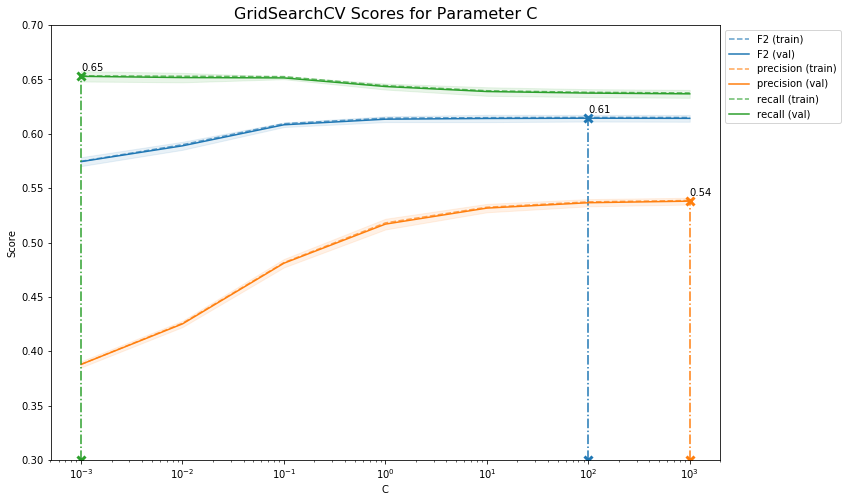

In [70]:
my_func.plot_gs_param(lr_c_gs, set_xscale='log', ylim=(0.3, 0.7), figsize=(12,8))

Decreasing C below the optimal F2 scoring value of 100 would be able to boost recall further, but the costs to precision are proportionally more and consequently unlikely to be worth it for the sake of balance.

Running through a full grid search of possible param for C, penalty, and class weight:

In [72]:
scoring={'F2': f2_score,
         'recall':'recall',
         'precision':'precision'}

param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'class_weight': ['balanced', None],
              'penalty': ['l1','l2']}

lr_gs = GridSearchCV(estimator=LogisticRegression(tol=0.001), # Slight reduce tol to improve comp time
                  param_grid = param_grid,
                  scoring=scoring,
                  cv=3,
                  refit=False,
                  n_jobs=4)

my_func.run_time(reset=True)
lr_gs.fit(X_train, y_train)
my_func.run_time()

Time: 121min 17s 


In [73]:
my_func.gs_score_summary(lr_gs)

--------------------
Best F2:
Params: {'C': 100, 'class_weight': 'balanced', 'penalty': 'l2'}
F2 = 0.6144170023787927
Recall = 0.6376811324672257
Precision = 0.5361982981963649
--------------------
Best Recall:
Params: {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2'}
F2 = 0.5743971115151113
Recall = 0.6528985258718123
Precision = 0.38786259744958895
--------------------
Best Precision:
Params: {'C': 0.001, 'class_weight': None, 'penalty': 'l1'}
F2 = 0.2494016740426696
Recall = 0.21001704469774352
Precision = 0.9981878533291695
--------------------


Our best F2 model acheives a recall of 0.61, versus the maximum potential of 0.65. Precision has been maintained at 0.53 which is at least still a slight improvement over the 0.5 of the uniform dummy model.

Testing this model on the full training validation sets:

In [74]:
lr_best = LogisticRegression(C=100, class_weight='balanced', penalty='l2')
lr_best.fit(X_train, y_train)

LogisticRegression(C=100, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [75]:
y_train_pred = lr_best.predict(X_train)
y_val_pred = lr_best.predict(X_val)

In [76]:
lr_train_summary = my_func.classifier_summary(y_train, y_train_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               85483               12831
Actual Positive                8487               14973
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.615443
Recall           0.638235
Precision (pos)  0.538520
Precision (neg)  0.909684
Specificity      0.869490


In [77]:
lr_val_summary = my_func.classifier_summary(y_val, y_val_pred)

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               21481                3149
Actual Positive                2090                3724
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.618009
Recall           0.640523
Precision (pos)  0.541830
Precision (neg)  0.911332
Specificity      0.872148


Comparing result between our training and validation sets, there appears to be little reason for concern in terms of overfitting.

### Feature Selection

In [172]:
np.rate?

In [253]:
np.argsort?

In [255]:
def rank_array(array, absolute=False, ascending=True):
    if absolute:
        temp = abs(array)
    else:
        temp = array
        
    if ascending:
        temp=temp.argsort()
    else:
        temp=temp.argsort()[::-1]
    
    ranks = np.empty(len(array), int)
    ranks[temp] = np.arange(len(array))
    
    return ranks

In [250]:
np.array([1,2,3,4,5])[::-1]

array([5, 4, 3, 2, 1])

In [182]:
pd.DataFrame?

In [201]:
np.reshape?

In [203]:
np.array(get_feature_prep_columns(feature_prep)).reshape(1,-1)

array([['funded_amnt_q10', 'int_rate_delta', 'annual_inc_q10', 'dti',
        'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'revol_bal_log',
        'revol_util', 'total_acc', 'collection_recovery_fee',
        'collections_12_mths_ex_med', 'acc_now_delinq', 'rev_lim_sqrt',
        'tot_cur_bal', 'tot_coll_amt', 'subgrade_p_value', 'lti', 'rbti',
        'tbti', 'cr_line_td_log', 'had_delinq', 'had_major_derog',
        'had_record', 'verified', 'emp_length_1 year',
        'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
        'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
        'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
        'emp_length_< 1 year', 'emp_length_n/a', 'purpose_car',
        'purpose_credit_card', 'purpose_debt_consolidation',
        'purpose_home_improvement', 'purpose_house',
        'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
        'purpose_other', 'purpose_renewable_energy',
    

In [235]:
lr_best.coef_.shape

(1, 57)

In [236]:
rank_coef(lr_best.coef_[0]).reshape(1,-1).shape

(1, 57)

In [259]:
data['train']['collection_recovery_fee'].value_counts()

0.0000       139215
18.0000           5
216.0000          5
144.0000          5
450.0000          4
36.0000           4
5.4400            3
9.4000            3
7.7300            3
18.5382           3
9.2690            3
2.0088            3
5.7500            3
936.0000          3
1.8000            3
180.0000          3
5.2000            3
108.0000          3
1.5800            3
3.1400            3
5.0400            3
1.5200            3
9.6355            3
2.7300            2
418.2444          2
2.3220            2
306.0000          2
7.9300            2
2.8000            2
190.3068          2
9.3821            2
227.5560          2
4.7900            2
900.0000          2
15.2184           2
9.5000            2
5.2727            2
4.0608            2
1146.7836         2
167.5656          2
29.5596           2
429.7914          2
8.1600            2
373.4514          2
6.2700            2
45.0000           2
20.4158           2
110.6748          2
5.8885            2
4.3500            2


In [256]:
pd.DataFrame(data={'feature': get_feature_prep_columns(feature_prep), 'coef': lr_best.coef_.reshape(-1)}, index=rank_array(lr_best.coef_[0], True, False)).sort_index()

,coef,feature
0,160.040205,collection_recovery_fee
1,6.899650,term_ 60 months
2,6.581289,term_ 36 months
3,4.081162,home_ownership_RENT
4,3.894905,home_ownership_MORTGAGE
5,3.864674,home_ownership_OWN
6,2.834706,home_ownership_OTHER
7,1.595778,emp_length_n/a
8,1.489248,purpose_small_business
9,1.432925,purpose_medical


In [164]:
def plot_RFE(estimator, X, y, step=1, cv=3, f_score=False, beta=1, n_jobs=1, figsize=(12,8)):
    scoring = {'precision': 'precision',
               'recall': 'recall'}
    f2_score = make_scorer(fbeta_score, beta=2)
    RFE = {}
    plt.clf()
    plt.figure(figsize=figsize)
    ax = plt.gca()
    for scorer in scoring:
        RFE[scorer] = RFECV(estimator=estimator, step=step, cv=cv, scoring=scoring[scorer], n_jobs=n_jobs)
        RFE[scorer].fit(X, y)
        ax.plot(range(1, len(RFE[scorer].grid_scores_) + 1), RFE[scorer].grid_scores_, label=scorer)
    
    min_score = min(min(RFE['recall'].grid_scores_), min(RFE['precision'].grid_scores_))
    max_score = max(max(RFE['recall'].grid_scores_), max(RFE['precision'].grid_scores_))
    
    ylim = ax.get_ylim()
    
    if f_score:
        f_scores = (1 + beta**2) * (RFE['recall'].grid_scores_ * RFE['precision'].grid_scores_) / ((beta**2 * RFE['precision'].grid_scores_) + RFE['recall'].grid_scores_)
        ax.plot(range(1, len(f_scores) + 1), f_scores, label='F'+str(beta), color='k', linestyle='--')
        best_score = np.argmax(f_scores)
        ax.plot([best_score+1,]*2, [ylim[0], f_scores[best_score]], linestyle='-.', color='k', lw=1, marker='x', markeredgewidth=2, ms=6)
        ax.annotate("%0.2f" % (f_scores[best_score]), (best_score+1, f_scores[best_score] + 0.01))
        ax.annotate("%0.0f" % (best_score+1), (best_score+1, ylim[0] + 0.01))
        RFE['F'+str(beta)] = f_scores
    
    plt.ylim(ylim)
    plt.xlabel('N Features Selected')
    plt.ylabel('Accuracy Score (CV={})'.format(cv))
    plt.title('Recursive Feature Elimination Scores')
    plt.legend(bbox_to_anchor=(1,1))    
    plt.show()
    return RFE

In [140]:
my_func.run_time(reset=True)
LogisticRegression(C=100, class_weight='balanced', penalty='l2').fit(X_train, y_train)
my_func.run_time()

Time: 18.01s 


In [167]:
rand_ind = np.random.choice(np.arange(0, X_train.shape[0], 1), size=50000, replace=False)

In [168]:
X_train_s = X_train[rand_ind]
y_train_s = y_train.iloc[rand_ind]

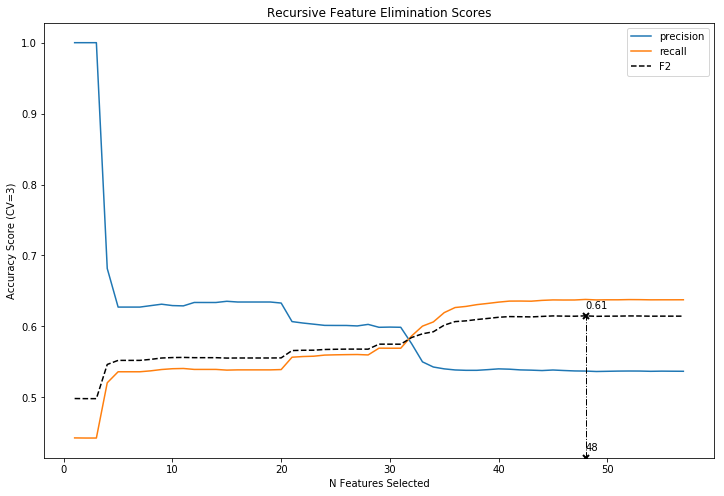

In [170]:
RFE = plot_RFE(LogisticRegression(C=100, class_weight='balanced', penalty='l2'), X_train, y_train, f_score=True, beta=2, n_jobs=2)

### Decision Threshold & PR Curve

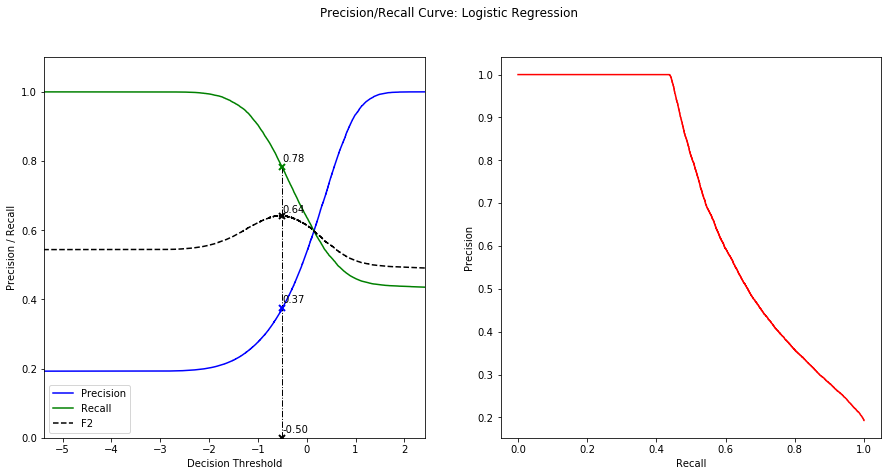

In [101]:
precisions, recalls, thresholds = my_func.plot_pr_curve(lr_best, X_train, y_train, f_score=True, beta=2, label='Logistic Regression')

In [ ]:
# Get threshold value for desired recall
desired_recall = 0.8
i = len(recalls) - np.argmax(recalls[::-1] > desired_recall) - 1
t = thresholds[i]
print('Threshold for Recall = {}: {:.3f}'.format(desired_recall, t))

In [132]:
# Filter results based off new threshold
y_train_pred_t = lr_best.decision_function(X_train) >= -.5
y_val_pred_t = lr_best.decision_function(X_val) >= -.5

In [130]:
my_func.classifier_summary(y_train, y_train_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               67713               30601
Actual Positive                5125               18335
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.642090
Recall           0.781543
Precision (pos)  0.374673
Precision (neg)  0.929638
Specificity      0.688742


In [134]:
my_func.classifier_summary(y_val, y_val_pred_t);

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               17039                7591
Actual Positive                1239                4575
--------------------
Accuracy Scores:
                    Score
Rate                     
F2               0.645785
Recall           0.786894
Precision (pos)  0.376048
Precision (neg)  0.932214
Specificity      0.691799
